In [ ]:
# Augmnetation pipeline

#we need to insepct the artifacted images like the stripped one and collect their id number
# for example # id_edges = [336, 338, 765, 1209, 2313, 2314, 2315, 2318, 2319,2336,2321]

#They undergone to different augmentation factos

#Move all the augmentation factor in utils or augmentation_utils file

In [5]:
from tqdm import tqdm

In [17]:
image_ids = [1,2,3, 4 ,5,6,7]

In [18]:
for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
    print(image_id)

100%|██████████| 7/7 [00:00<00:00, 1718.17it/s]

1
2
3
4
5
6
7


In [1]:
import glob
import sys
import numpy as np
import imageio
import cv2
import random
from skimage import transform
import os
from tqdm import tqdm
from subprocess import check_output
import matplotlib.pyplot as plt
from importlib import import_module
from skimage import io
import skimage.io
from skimage.transform import rotate
from skimage.transform import resize
from subprocess import check_output
import albumentations as alb
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.morphology import watershed, remove_small_holes, remove_small_objects, label, erosion
from skimage.feature import peak_local_max

In [2]:
LoadImagesForAug =  './DATASET/TRAIN_VAL/all_cropped_images/images/'
LoadLabelsForAug = './DATASET/TRAIN_VAL/all_weighted_masks/masks/'
SaveAugImages =  './DATASET/TRAIN_VAL/all_cropped_images/images/'
SaveAugMasks = './DATASET/TRAIN_VAL/all_weighted_masks/masks/'

image_ids = os.listdir('./DATASET/TRAIN_VAL/all_cropped_images/images/')
IMG_WIDTH = 1600
IMG_HEIGTH = 1200

In [45]:
# id_edges = [336, 338, 765, 1209, 2313, 2314, 2315, 2318, 2319,2336,2321]

In [3]:
from albumentations import (RandomCrop,CenterCrop,ElasticTransform,RGBShift,Rotate,
    Compose, ToFloat, FromFloat, RandomRotate90, Flip, OneOf, MotionBlur, MedianBlur, Blur,Transpose,
    ShiftScaleRotate, OpticalDistortion, GridDistortion, RandomBrightnessContrast, VerticalFlip, HorizontalFlip,
    
    HueSaturationValue,
)


In [4]:
def lookup_tiff_aug(p = 0.5):
    
    return Compose([

        ToFloat(),
        
        #LOOKUP TABLE    
        OneOf([ 
        RandomBrightnessContrast(brightness_limit=0,contrast_limit=(-0.7,0.0), p=0.7),
        HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, val_shift_limit=0.05, p=0.7),

            ], p=p),
        
        FromFloat(dtype='uint8', max_value=255.0),

            ], p=p)


def shifter_RGB(p = 0.5):
    
        return Compose([

        ToFloat(),
        
        #LOOKUP TABLE    
        OneOf([ 
        RGBShift(r_shift_limit=[0.05,0.06], g_shift_limit=[0.04,0.045], b_shift_limit=0, p=1),
            ], p=p),
        
        FromFloat(dtype='uint8', max_value=255.0),

            ], p=p)


def shifter(p=.5):
    return Compose([
        ToFloat(),

        #ROTATION
        Rotate(limit=180, interpolation=1, border_mode=4, always_apply=False, p=0.75),
#         #FLIP
        OneOf([
            VerticalFlip(p = 0.6),
            HorizontalFlip(p = 0.6),
                ], p=p),
        
        FromFloat(dtype='uint8', max_value=255.0),
        
        ], p=p)


def elastic_def(alpha, alpha_affine, sigma, p=.5):
    return Compose([
        ToFloat(),

        ElasticTransform(alpha=alpha, sigma=sigma, alpha_affine=alpha_affine, interpolation=1, border_mode=4, 
                             always_apply=False, approximate=False, 
                             p=1),
        ShiftScaleRotate(shift_limit=0.10, scale_limit=0, rotate_limit=(0, 0),
                         interpolation=1, border_mode=4, always_apply=False, p=0.3),
        
        FromFloat(dtype='uint8', max_value=255.0),
        

    ], p=p)

def edges_aug(p = 0.5):
    return Compose([

        ToFloat(),
        
        #LOOKUP TABLE    
        OneOf([ 
        HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.10, val_shift_limit=0.1, p=0.75),
        RandomBrightnessContrast(brightness_limit=0, contrast_limit=0.4,p=0.75),
        ], p=0.6),
        
        FromFloat(dtype='uint8', max_value=255.0),

    ], p=p)


def Gaussian(p=.5, blur_limit = 25):
    return Compose([
        ToFloat(),

            OneOf([
            Blur(blur_limit=25, p=1),
        ], p=1),
        
        FromFloat(dtype='uint8', max_value=255.0),
        

    ], p=p)

In [ ]:
def data_aug(image ,mask, image_id, nlabels_tar, minimum, maximum):

    gaussian = random.random()
    generic_transf = random.random()
    elastic = random.random()
    resize = random.random()
    RGB = random.random()
    
    rows,cols,ch = image.shape
    rowsm,colsm,chm = mask.shape
    
    # if lower < 0.08:
        # image = image.astype(np.float)
        # image *= 0.4
        # image = image.astype(np.uint8)
        
        # return image, mask

    if (RGB < 0.05) & (nlabels_tar > 2):
       
        augmentation = shifter_RGB(p = 1)
        data = {"image": image}
        augmented = augmentation(**data)
        image = augmented["image"]
        
        augmentation = shifter(p = 0.5)
        data = {"image": image, "mask": mask}
        augmented = augmentation(**data)
        image, mask = augmented["image"], augmented["mask"] 
        
        mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
        # if gaussian <= 0.10:
            
            # gaussian_blur = Gaussian_y(p=1, blur_limit = 15)
            # data = {"image": image}
            # augmented = gaussian_blur(**data)
            # image = augmented["image"] 
            

        return image, mask
    
            
    #65 before
    if generic_transf < 0.65:
       
        augmentation = lookup_tiff_aug(p = 0.7)
        data = {"image": image}
        augmented = augmentation(**data)
        image = augmented["image"]
        
        augmentation = shifter(p = 0.7)
        data = {"image": image, "mask": mask}
        augmented = augmentation(**data)
        image, mask = augmented["image"], augmented["mask"] 
        
        mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
        if gaussian <= 0.33:
            
            gaussian_blur = Gaussian(p=1, blur_limit = 15)
            data = {"image": image}
            augmented = gaussian_blur(**data)
            image = augmented["image"] 
            

        return image, mask
    

    if elastic < 0.9:
        
        alfa = random.choice([30, 30, 40, 40, 40 , 50, 60])
        alfa_affine = random.choice([40, 50, 50, 75, 75])
        sigma = random.choice([20, 30, 30, 40, 50])
        elastic = elastic_def(alfa, alfa_affine, sigma, p=1)
        data = {"image": image, "mask": mask}
        augmented = elastic(**data)
        image, mask = augmented["image"], augmented["mask"]      

        mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)        

        return image, mask

    else:
        
        augmentation = shifter(p = 1)
        data = {"image": image, "mask": mask}
        augmented = augmentation(**data)
        image, mask = augmented["image"], augmented["mask"]
        
        mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
        return image, mask
    
    if resize <= 0.1:

        res = 0.5  
        scaled_image = cv2.resize(image,(int(cols*res),int(rows*res))) # scale image if you want resize the input andoutput image must be the same
        scaled_mask = cv2.resize(mask,(int(cols*res),int(rows*res)))
        bordersize = rows//4
        b, g, r = cv2.split(image)
        blu = b.mean()
        green = g.mean()
        red = r.mean()
        image=cv2.copyMakeBorder(scaled_image, top=bordersize, bottom=bordersize, left=bordersize, 
                             right=bordersize, borderType= cv2.BORDER_CONSTANT, value=[blu,green,red])
        mask=cv2.copyMakeBorder(scaled_mask, top=bordersize, bottom=bordersize, left=bordersize, 
                            right=bordersize, borderType= cv2.BORDER_CONSTANT)
                            
        mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
        return image, mask

In [6]:
# account fot different augmentation factor
2556 + 2556*4 + (2556-2304)*10 +(80+35+13)*10

16580

In [596]:
def make_data_augmentation(image_ids, split_num,split_num_new_images, ix, SaveAugImages, SaveAugMasks):
    
    for ax_index, image_id in tqdm(enumerate(image_ids),total=len(image_ids)):
        
        ID = int(image_id.split('.')[0])

        image, mask = read_image_labels(image_id)
        
        minimum = mask[:,:,1:2].min()
        maximum = mask[:,:,1:2].max()
        labels_tar, nlabels_tar = ndimage.label(np.squeeze(mask[:,:,0:1]))

#         target = mask[:,:,0:1].astype(bool)
#         target = remove_small_objects(target,min_size = 30)    
#         mask[:,:,0:1] = target.astype(np.uint8)*255
        
        
        if ID > 2304:
            split_num = split_num_new_images
        
        if ID in id_edges:
            
            print(ID, ix)
            
            for i in range(80):
                
                image, mask = read_image_labels(image_id)

                augmentation = edges_aug(p = 1)
                data = {"image": image}
                augmented = augmentation(**data)
                new_image = augmented["image"]
                
                augmentation = shifter(p = 0.8)
                data = {"image": new_image, "mask": mask}
                augmented = augmentation(**data)
                new_image, new_mask = augmented["image"], augmented["mask"]
                
                new_mask[:,:,1:2] =np.clip(new_mask[:,:,1:2], minimum, maximum)
                
                aug_img_dir = SaveAugImages + '{}.tiff'.format(ix)
                aug_mask_dir = SaveAugMasks + '{}.tiff'.format(ix)
                ix +=1

                plt.imsave(fname=aug_img_dir, arr = new_image)
                plt.imsave(fname=aug_mask_dir,arr = new_mask)
                
            for i in range(35):
                
                image, mask = read_image_labels(image_id)
                 
                alfa = random.choice([30,30,30, 40])
                alfa_affine = random.choice([20,20,20,30, 40, 40])
                sigma = random.choice([20, 20, 20, 20, 30, 30, 15])
                
                elastic = elastic_def(alfa, alfa_affine, sigma, p=1)
                data = {"image": image, "mask": mask}
                augmented = elastic(**data)
                new_image, new_mask = augmented["image"], augmented["mask"] 
                
                new_mask[:,:,1:2] =np.clip(new_mask[:,:,1:2], minimum, maximum)

#                 new_image = new_image*1./255
#                 new_mask = new_mask*1./255

#                 new_image.astype(float)
#                 new_mask.astype(float)

                aug_img_dir = SaveAugImages + '{}.tiff'.format(ix)
                aug_mask_dir = SaveAugMasks + '{}.tiff'.format(ix)
                ix +=1

                plt.imsave(fname=aug_img_dir, arr = new_image)
                plt.imsave(fname=aug_mask_dir,arr = new_mask)
                
            for blur in range(1 , 39, 3):
                
                image, mask = read_image_labels(image_id)
                
                blur_limit = blur
                gaussian_blur = Gaussian(p = 1, blur_limit= blur_limit)
                data = {"image": image}
                augmented = gaussian_blur(**data)
                new_image = augmented["image"]   

                
                aug_img_dir = SaveAugImages + '{}.tiff'.format(ix)
                aug_mask_dir = SaveAugMasks + '{}.tiff'.format(ix)
                ix +=1

                plt.imsave(fname=aug_img_dir, arr = new_image)
                plt.imsave(fname=aug_mask_dir,arr = mask)
                
                
        else:
    
            for i in range(split_num):

                new_image, new_mask = data_aug(image, mask, image_id, nlabels_tar,minimum, maximum)

                aug_img_dir = SaveAugImages + '{}.tiff'.format(ix)
                aug_mask_dir = SaveAugMasks + '{}.tiff'.format(ix)
                ix +=1

                plt.imsave(fname=aug_img_dir, arr = new_image)
                plt.imsave(fname=aug_mask_dir, arr = new_mask)
                          

In [8]:
def read_image_labels(image_id):
     
        image = cv2.imread(LoadImagesForAug + image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(LoadLabelsForAug + image_id)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        return image, mask

In [9]:
# image_ids = [str(x)+'.tiff' for x in range(2316)]
image_ids = [str(x)+'.tiff' for x in range(2556)]

shift = len(image_ids)

In [12]:
2556*5+2556

15336

In [10]:
split_num = 5
#split num for relevant images
split_num_new_images = 11
make_data_augmentation(image_ids, split_num, split_num_new_images, shift, SaveAugImages, SaveAugMasks)

100%|██████████| 2556/2556 [30:23<00:00,  1.40it/s]


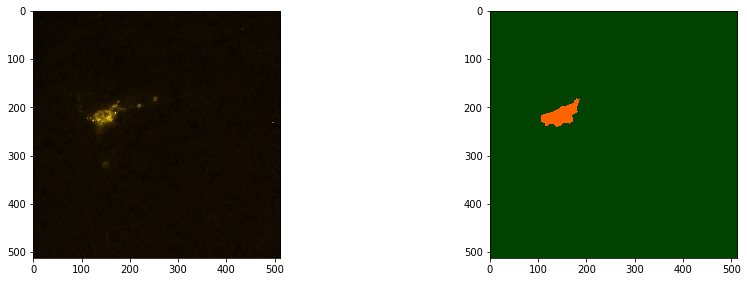

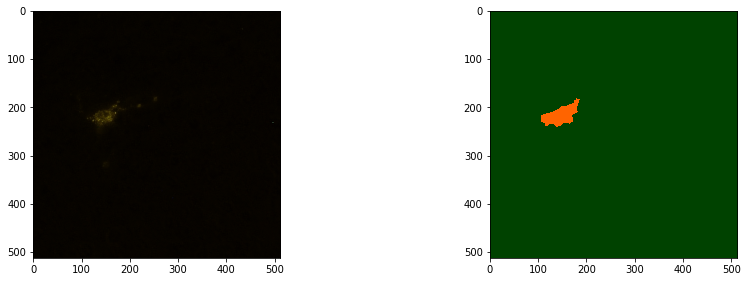

In [592]:
image_id = image_ids[random.randint(0,np.floor(len(image_ids))-1)]
image, mask = read_image_labels(image_id)

minimum = mask[:,:,1:2].min()
maximum = mask[:,:,1:2].max()
labels_tar, nlabels_tar = ndimage.label(np.squeeze(mask[:,:,0:1]))

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(np.squeeze(mask))
new_image, new_labels = data_aug(image, mask, image_id,nlabels_tar, minimum, maximum)
if len(new_image.shape)==3:
    plt.figure(figsize=(15,10))
    plt.subplot(223)
    plt.imshow(new_image)
    plt.subplot(224)
    plt.imshow(np.squeeze(new_labels))
else:
    print('yes')
    plt.figure(figsize=(15,10))
    plt.subplot(223)
    plt.imshow(new_image[1])
    plt.subplot(224)
    plt.imshow(np.squeeze(new_labels[1]))

In [1085]:
np.unique(new_image)

array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. , 4.4, 4.8,
       5.2, 5.6, 6. ])

In [473]:
img, mask = read_image_labels('0.TIF')

In [474]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [479]:
h, s, v = hsv_img[:, :, 0]/255, hsv_img[:, :, 1]/255, hsv_img[:, :, 2]/255

In [ ]:
def data_aug(image ,mask, image_id, nlabels_tar, minimum, maximum):
    
#     image_id = int(image_id.split('.')[0])
#     gaussian = random.random()
#     generic_transf = random.random()
#     elastic = random.random()
#     resize = random.random()
#     RGB = random.random()
#     lower = random.random()
    
    
#     rows,cols,ch = image.shape
#     rowsm,colsm,chm = mask.shape
    
# #     if lower < 1:
# #         image = image.astype(np.float)
# #         image *= 0.4
# #         image = image.astype(np.uint8)
        
# #         return image, mask

#     if (RGB < 0.2):
       
#         augmentation = shifter_RGB(p = 1)
#         data = {"image": image}
#         augmented = augmentation(**data)
#         image = augmented["image"]
        
#         augmentation = shifter(p = 0.5)
#         data = {"image": image, "mask": mask}
#         augmented = augmentation(**data)
#         image, mask = augmented["image"], augmented["mask"] 
        
#         mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
             

#         return image, mask
    
    
# #     if resize <= 0.05:

# #         res = 0.5  
# #         scaled_image = cv2.resize(image,(int(cols*res),int(rows*res))) # scale image if you want resize the input andoutput image must be the same
# #         scaled_mask = cv2.resize(mask,(int(cols*res),int(rows*res)))
# #         bordersize = rows//4
# #         b, g, r = cv2.split(image)
# #         blu = b.mean()
# #         green = g.mean()
# #         red = r.mean()
# #         image=cv2.copyMakeBorder(scaled_image, top=bordersize, bottom=bordersize, left=bordersize, 
# #                              right=bordersize, borderType= cv2.BORDER_CONSTANT, value=[blu,green,red])
# #         mask=cv2.copyMakeBorder(scaled_mask, top=bordersize, bottom=bordersize, left=bordersize, 
# #                             right=bordersize, borderType= cv2.BORDER_CONSTANT)
        
# #         mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
# #         return image, mask

#     if generic_transf < 0.7:
       
#         augmentation = lookup_tiff_aug(p = 1)
#         data = {"image": image}
#         augmented = augmentation(**data)
#         image = augmented["image"]
        
#         augmentation = shifter(p = 0.6)
#         data = {"image": image, "mask": mask}
#         augmented = augmentation(**data)
#         image, mask = augmented["image"], augmented["mask"] 
        
#         mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
#         if gaussian <= 0.05:
            
#             gaussian_blur = Gaussian(p=1, blur_limit = 9)
#             data = {"image": image}
#             augmented = gaussian_blur(**data)
#             image = augmented["image"] 
            

#         return image, mask
    

#     if elastic <= 1:
        
#         alfa = random.choice([30, 30, 40, 40, 40 , 50, 60])
#         alfa_affine = random.choice([40, 50, 50, 75, 75])
#         sigma = random.choice([20, 30, 30, 40, 50])
#         elastic = elastic_def(alfa, alfa_affine, sigma, p=1)
#         data = {"image": image, "mask": mask}
#         augmented = elastic(**data)
#         image, mask = augmented["image"], augmented["mask"]
        
#         mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)

#         return image, mask

# #     else:
        
# #         augmentation = shifter(p = 1)
# #         data = {"image": image, "mask": mask}
# #         augmented = augmentation(**data)
# #         image, mask = augmented["image"], augmented["mask"]
        
# #         mask[:,:,1:2] =np.clip(mask[:,:,1:2], minimum, maximum)
        
# #         return image, mask